## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
from pathlib import Path

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
sys.path.append('/home/k64835/Master-Thesis-SITS')

scripts_path = Path("../Data-Preprocessing/").resolve()
sys.path.append(str(scripts_path))

scripts_path = Path("../Evaluation/").resolve()
sys.path.append(str(scripts_path))

In [27]:
import pickle
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestCentroid
from scripts.data_visualiser import *
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from model_scripts.subpatch_extraction import *
from scripts.data_loader import *
from scripts.data_preprocessor import *
from scripts.temporal_data_preprocessor import *
from scripts.temporal_data_loader import *
from scripts.temporal_visualiser import *
from scripts.temporal_chanel_refinement import *
from model_scripts.model_helper import *
from model_scripts.dataset_creation import *
from model_scripts.train_model_ae import *
from model_scripts.model_visualiser import *
from model_scripts.clustering import *
from model_scripts.train_model_dcec import *
from evaluation_scripts.evaluation_helper import *
from evaluation_scripts.result_visualiser import *
from Pipeline.temporal_preprocessing_pipeline import *
from evaluation_scripts.result_visualiser import *
from Pipeline.temporal_preprocessing_pipeline import *
import numpy as np
import config as config
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import skimage.measure
import torch
import torch.nn as nn
import torch.optim as optim

## DCEC

In [5]:
# # No aggregations, simple convolutions

# class Conv3DAutoencoder(nn.Module):
#     def __init__(self, in_channels, time_steps, latent_size, patch_size):
#         super(Conv3DAutoencoder, self).__init__()

#         self.in_channels = in_channels
#         self.time_steps = time_steps
#         self.patch_size = patch_size

#         # Encoder
#         self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=3, stride=1, padding=1)
#         self.conv2 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
#         self.conv3 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)

#         # Latent Space
#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Linear(256 * time_steps * patch_size * patch_size, latent_size)

#         # Decoder
#         self.fc2 = nn.Linear(latent_size, 256 * time_steps * patch_size * patch_size)
#         self.unflatten = nn.Unflatten(1, (256, time_steps, patch_size, patch_size))

#         self.deconv1 = nn.ConvTranspose3d(256, 128, kernel_size=3, stride=1, padding=1)
#         self.deconv2 = nn.ConvTranspose3d(128, 64, kernel_size=3, stride=1, padding=1)
#         self.deconv3 = nn.ConvTranspose3d(64, in_channels, kernel_size=3, stride=1, padding=1)

#     def forward(self, x):
#         # Encoder
#         x = F.relu(self.conv1(x))  
#         x = F.relu(self.conv2(x))  
#         x = F.relu(self.conv3(x))  

#         x = self.flatten(x)
#         z = F.relu(self.fc1(x))  

#         # Decoder
#         x = F.relu(self.fc2(z))  
#         x = self.unflatten(x)  

#         x = F.relu(self.deconv1(x))  
#         x = F.relu(self.deconv2(x))  
#         x_reconstructed = self.deconv3(x)  

#         return z, x_reconstructed


# class ClusteringLayer(nn.Module):
#     def __init__(self, n_clusters, latent_size):
#         super(ClusteringLayer, self).__init__()
#         self.n_clusters = n_clusters
#         self.cluster_centers = nn.Parameter(torch.randn(n_clusters, latent_size, requires_grad=True))


#     def forward(self, z):
#         q = 1.0 / (1.0 + torch.sum((z.unsqueeze(1) - self.cluster_centers) ** 2, dim=2))
#         q = q / q.sum(dim=1, keepdim=True)
#         return q

# class DCEC(nn.Module):
#     def __init__(self, in_channels, time_steps, latent_size, patch_size, n_clusters):
#         super(DCEC, self).__init__()
#         self.autoencoder = Conv3DAutoencoder(in_channels, time_steps, latent_size, patch_size)
#         self.clustering_layer = ClusteringLayer(n_clusters, latent_size)

#     def forward(self, x):
#         z, x_reconstructed = self.autoencoder(x)
#         q = self.clustering_layer(z)
#         return q, x_reconstructed


#     def init_clusters(self, dataloader, random_state=42, device='mps'):
#         self.to(device)
#         z_values = []
        
#         with torch.no_grad():
#             for x_batch, _ in dataloader:
#                 x_batch = x_batch.to(device)
#                 z, _ = self.autoencoder(x_batch)
#                 z_values.append(z.cpu().numpy())
        
#         z_values = np.concatenate(z_values, axis=0)
#         kmeans = KMeans(n_clusters=self.clustering_layer.n_clusters, n_init=20, random_state=random_state)
#         cluster_centers = kmeans.fit(z_values).cluster_centers_
        
#         self.clustering_layer.cluster_centers.data = torch.tensor(cluster_centers, dtype=torch.float32, device=device)

In [22]:
# Time aggregation, channel expansion
class Conv3DAutoencoder(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv3DAutoencoder, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels

        # Encoder
        self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(64, 256, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(256, 512, kernel_size=3, stride=1, padding=1)

        # 1D Convolution for Time Aggregation
        self.conv1d = nn.Conv1d(512 * patch_size * patch_size, 512 * patch_size * patch_size, kernel_size=time_steps, stride=1, padding=0, groups=512)

        # Fully Connected Layers for Latent Space
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512 * patch_size * patch_size, latent_size)

        # Decoder
        self.fc2 = nn.Linear(latent_size, 512 * patch_size * patch_size)

        # 1D Deconvolution to Restore Time Dimension
        self.deconv1d = nn.ConvTranspose1d(512 * patch_size * patch_size, 512 * patch_size * patch_size, kernel_size=time_steps, stride=1, padding=0, groups=512)

        # 3D Deconvolutions
        self.unflatten = nn.Unflatten(1, (512, patch_size, patch_size))
        self.deconv1 = nn.ConvTranspose3d(512, 256, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose3d(256, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose3d(64, in_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # Encoder
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # Reshape for 1D Convolution
        b, c, t, h, w = x.shape
        x = x.view(b, c * h * w, t)
        x = self.conv1d(x)

        # Fully Connected Latent Space
        x = self.flatten(x)
        z = F.relu(self.fc1(x))

        # Decoder
        x = F.relu(self.fc2(z))

        # Restore Time Dimension
        x = x.view(b, 512 * h * w, 1)
        x = self.deconv1d(x)

        # Reshape for 3D Deconvolutions
        x = x.view(b, 512, self.time_steps, h, w)

        # 3D Deconvolutions
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x_reconstructed = self.deconv3(x)

        return z, x_reconstructed

class ClusteringLayer(nn.Module):
    def __init__(self, n_clusters, latent_size):
        super(ClusteringLayer, self).__init__()
        self.n_clusters = n_clusters
        self.cluster_centers = nn.Parameter(torch.randn(n_clusters, latent_size))

    def forward(self, z):
        q = 1.0 / (1.0 + torch.sum((z.unsqueeze(1) - self.cluster_centers) ** 2, dim=2))
        q = q / q.sum(dim=1, keepdim=True)
        return q

class DCEC(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size, n_clusters):
        super(DCEC, self).__init__()
        self.autoencoder = Conv3DAutoencoder(in_channels, time_steps, latent_size, patch_size)
        self.clustering_layer = ClusteringLayer(n_clusters, latent_size)

    def forward(self, x):
        z, x_reconstructed = self.autoencoder(x)
        q = self.clustering_layer(z)
        return q, x_reconstructed


    def init_clusters(self, dataloader, random_state=42, device='mps'):
        self.to(device)
        z_values = []
        
        with torch.no_grad():
            for x_batch, _ in dataloader:
                x_batch = x_batch.to(device)
                z, _ = self.autoencoder(x_batch)
                z_values.append(z.cpu().numpy())
        
        z_values = np.concatenate(z_values, axis=0)
        kmeans = KMeans(n_clusters=self.clustering_layer.n_clusters, n_init=20, random_state=random_state)
        cluster_centers = kmeans.fit(z_values).cluster_centers_
        
        self.clustering_layer.cluster_centers.data = torch.tensor(cluster_centers, dtype=torch.float32, device=device)

In [7]:
# Channel aggregation, time expansion
# class Conv3DAutoencoder(nn.Module):
#     def __init__(self, in_channels, time_steps, latent_size, patch_size):
#         super(Conv3DAutoencoder, self).__init__()

#         self.time_steps = time_steps
#         self.in_channels = in_channels

#         # Encoder - Expand time instead of channels
#         self.conv1 = nn.Conv3d(time_steps, 64, kernel_size=3, stride=1, padding=1)  # Time is treated as channels
#         self.conv2 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
#         self.conv3 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)

#         # Fully Connected Latent Space
#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Linear(256 * patch_size * patch_size * in_channels, 512)
#         self.fc2 = nn.Linear(512, latent_size)

#         # Decoder - Expand spatial/spectral before time
#         self.fc3 = nn.Linear(latent_size, 512)
#         self.fc4 = nn.Linear(512, 256 * patch_size * patch_size * in_channels)

#         # Unflatten for deconvolution
#         self.unflatten = nn.Unflatten(1, (256, in_channels, patch_size, patch_size))

#         # 3D Deconvolutions
#         self.deconv1 = nn.ConvTranspose3d(256, 128, kernel_size=3, stride=1, padding=1)
#         self.deconv2 = nn.ConvTranspose3d(128, 64, kernel_size=3, stride=1, padding=1)
#         self.deconv3 = nn.ConvTranspose3d(64, time_steps, kernel_size=3, stride=1, padding=1)  # Expand back to time

#     def forward(self, x):
#         # Reshape: (B, C, T, H, W) → (B, T, C, H, W)
#         x = x.permute(0, 2, 1, 3, 4)

#         # Encoder - Expand time instead of channels
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         x = F.relu(self.conv3(x))

#         # print(x.shape)

#         # Flatten for fully connected layers
#         b, c, t, h, w = x.shape
#         x = self.flatten(x)  
#         x = F.relu(self.fc1(x))
#         z = self.fc2(x)

#         # print(x.shape)

#         # Decoder - Restore spatial/spectral before time
#         x = F.relu(self.fc3(z))
#         x = F.relu(self.fc4(x))

#         # print(x.shape)

#         # Reshape for deconvolutions
#         x = self.unflatten(x)  
#         x = F.relu(self.deconv1(x))
#         x = F.relu(self.deconv2(x))

#         # print(x.shape)

#         x_reconstructed = self.deconv3(x)  # Expand back to time

#         # Reshape back to (B, C, T, H, W)
#         x_reconstructed = x_reconstructed.permute(0, 2, 1, 3, 4)

#         return z, x_reconstructed



# class ClusteringLayer(nn.Module):
#     def __init__(self, n_clusters, latent_size):
#         super(ClusteringLayer, self).__init__()
#         self.n_clusters = n_clusters
#         self.cluster_centers = nn.Parameter(torch.randn(n_clusters, latent_size))

#     def forward(self, z):
#         q = 1.0 / (1.0 + torch.sum((z.unsqueeze(1) - self.cluster_centers) ** 2, dim=2))
#         q = q / q.sum(dim=1, keepdim=True)
#         return q

# class DCEC(nn.Module):
#     def __init__(self, in_channels, time_steps, latent_size, patch_size, n_clusters):
#         super(DCEC, self).__init__()
#         self.autoencoder = Conv3DAutoencoder(in_channels, time_steps, latent_size, patch_size)
#         self.clustering_layer = ClusteringLayer(n_clusters, latent_size)

#     def forward(self, x):
#         z, x_reconstructed = self.autoencoder(x)
#         q = self.clustering_layer(z)
#         return q, x_reconstructed

#     def init_clusters(self, dataloader, random_state=42, device='mps'):
#         self.to(device)
#         z_values = []
        
#         with torch.no_grad():
#             for x_batch, _ in dataloader:
#                 x_batch = x_batch.to(device)
#                 z, _ = self.autoencoder(x_batch)
#                 z_values.append(z.cpu().numpy())
        
#         z_values = np.concatenate(z_values, axis=0)
#         kmeans = KMeans(n_clusters=self.clustering_layer.n_clusters, n_init=20, random_state=random_state)
#         cluster_centers = kmeans.fit(z_values).cluster_centers_
        
#         self.clustering_layer.cluster_centers.data = torch.tensor(cluster_centers, dtype=torch.float32, device=device)


## Experiment 2: B10 + DCEC

### Loading the pre-processed data

Data: Extracted and Pre-processed Patches (each patch containing a sugarbeet field)

Dimensions: (N, T, C, H, W) = (N, 7, 10, 64, 64)

In [10]:
preprocessing_pipeline = PreProcessingPipelineTemporal()
field_numbers_train, acquisition_dates_train, patch_tensor_train, images_visualisation_train = preprocessing_pipeline.get_processed_temporal_cubes('train', 'allbands')
field_numbers_eval, acquisition_dates_eval, patch_tensor_eval, images_visualisation_eval = preprocessing_pipeline.get_processed_temporal_cubes('eval', 'allbands')
patch_tensor_train.shape, patch_tensor_eval.shape

(torch.Size([2425, 7, 10, 64, 64]), torch.Size([48, 7, 10, 64, 64]))

### Create Sub-Patches

In [11]:
train_subpatches, train_subpatch_coords = non_overlapping_sliding_window(patch_tensor_train, field_numbers_train, patch_size=config.subpatch_size)
eval_subpatches, eval_subpatch_coords = non_overlapping_sliding_window(patch_tensor_eval, field_numbers_eval, patch_size=config.subpatch_size)
train_subpatches.shape, eval_subpatches.shape

(torch.Size([39042, 7, 10, 5, 5]), torch.Size([867, 7, 10, 5, 5]))

Get field numbers and co-ordinates as string

In [16]:
train_coord_dataloader = get_string_fielddata(train_subpatch_coords)
eval_coord_dataloader = get_string_fielddata(eval_subpatch_coords)
train_coord_dataloader[0]

'1167134.0_25_25'

### Split Unlabeled data into 'train' and 'test' and create  Data Loaders

In [17]:
train_subpatches_dl, test_subpatches, train_field_numbers, test_field_numbers = train_test_split(
    train_subpatches, train_coord_dataloader, test_size=1-0.75, random_state=40
)

dataloader_train = create_data_loader(train_subpatches_dl, train_field_numbers, batch_size=config.ae_batch_size, shuffle=True)
dataloader_test = create_data_loader(test_subpatches, test_field_numbers, batch_size=config.ae_batch_size, shuffle=False)
dataloader_eval = create_data_loader(eval_subpatches, eval_coord_dataloader, batch_size=config.ae_batch_size, shuffle=False)

### Training the Auto-encoder

Input Data: ( N x C x D x H x W )

Params

In [28]:
device = 'cuda'
epochs = 50
lr = 0.001
momentum = 0.8
latent_dim=16
channels = 10
time_steps = 7
alpha = 0.1
patch_size = config.subpatch_size

Step 1: Pre-training the Autoencoder just the Autoencoder Part

In [30]:
model = DCEC(in_channels=channels, time_steps=time_steps, latent_size=latent_dim, patch_size=patch_size, n_clusters=2)

pretrained_model = pretrain_autoencoder(model, dataloader_train, dataloader_test, epochs=10)

Epoch 1/10 - Autoencoder Train Loss: 0.0036 | Test Loss: 0.0026
Epoch 2/10 - Autoencoder Train Loss: 0.0026 | Test Loss: 0.0026
Epoch 3/10 - Autoencoder Train Loss: 0.0026 | Test Loss: 0.0028
Epoch 4/10 - Autoencoder Train Loss: 0.0026 | Test Loss: 0.0026
Epoch 5/10 - Autoencoder Train Loss: 0.0026 | Test Loss: 0.0026
Epoch 6/10 - Autoencoder Train Loss: 0.0026 | Test Loss: 0.0026
Epoch 7/10 - Autoencoder Train Loss: 0.0026 | Test Loss: 0.0027
Epoch 8/10 - Autoencoder Train Loss: 0.0026 | Test Loss: 0.0025
Epoch 9/10 - Autoencoder Train Loss: 0.0026 | Test Loss: 0.0026
Epoch 10/10 - Autoencoder Train Loss: 0.0026 | Test Loss: 0.0026
Autoencoder Pretraining Complete!


Step 2: Initialising the cluster centers

In [31]:
initialize_clusters(model, dataloader_train)

Cluster Centers Initialized!


/home/k64835/.local/lib/python3.8/site-packages/sklearn/base.py:1152: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Step 3: DCEC Training the full Clustering Layer

In [ ]:
# device = 'cuda'
# epochs = 50
# lr = 0.001
# momentum = 0.8
# latent_dim=16
# channels = 10
# time_steps = 7
# alpha = 0.1
# patch_size = config.subpatch_size

# model = DCEC(channels, time_steps, latent_dim, patch_size, 2)
# model.init_clusters(dataloader_train, random_state=20, device=device)

In [32]:
trained_model, losses = train_dcec(model, dataloader_train, dataloader_test, epochs=epochs, lr=lr, alpha=alpha, device=device)

Epoch 1/50:
  Train - Reconstruction Loss: 0.002578, Clustering Loss: 0.000000
  Test  - Reconstruction Loss: 0.002578, Clustering Loss: 0.000000
Epoch 2/50:
  Train - Reconstruction Loss: 0.002566, Clustering Loss: 0.000000
  Test  - Reconstruction Loss: 0.002597, Clustering Loss: 0.000000
Epoch 3/50:
  Train - Reconstruction Loss: 0.002561, Clustering Loss: 0.000000
  Test  - Reconstruction Loss: 0.002622, Clustering Loss: 0.000000
Epoch 4/50:
  Train - Reconstruction Loss: 0.002559, Clustering Loss: 0.000000
  Test  - Reconstruction Loss: 0.002536, Clustering Loss: 0.000000
Epoch 5/50:
  Train - Reconstruction Loss: 0.003185, Clustering Loss: 0.000000
  Test  - Reconstruction Loss: 0.002542, Clustering Loss: 0.000000
Epoch 6/50:
  Train - Reconstruction Loss: 0.002562, Clustering Loss: 0.000000
  Test  - Reconstruction Loss: 0.002536, Clustering Loss: 0.000000


KeyboardInterrupt: 

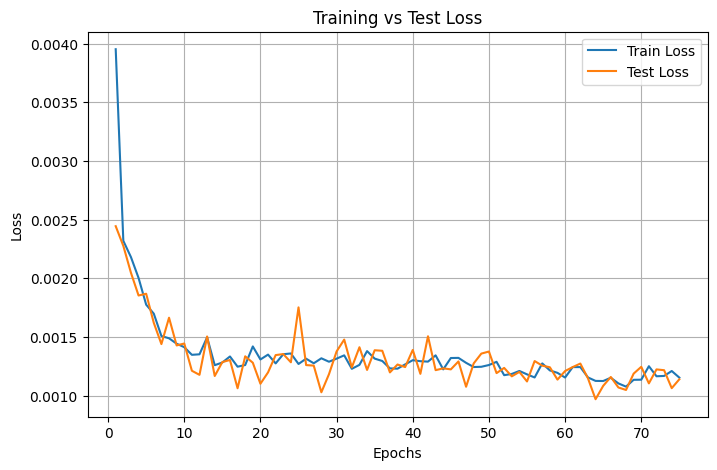

In [100]:
plot_loss(losses['train_reconstruction_loss'], losses['test_reconstruction_loss'])

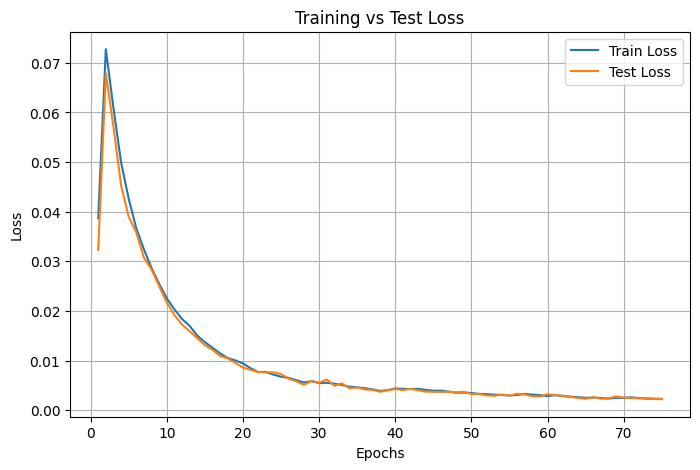

In [101]:
plot_loss(losses['train_clustering_loss'], losses['test_clustering_loss'])

### Evaluation

Use Encoder part and clustering layer to get the clustering assignments and features

In [102]:
train_latent_features, train_cluster_assignments, train_coord_dl = evaluate_dcec(trained_model, dataloader_train, device)
test_latent_features, test_cluster_assignments, test_coord_dl = evaluate_dcec(trained_model, dataloader_test, device)
eval_latent_features, eval_cluster_assignments, eval_coord_dl = evaluate_dcec(trained_model, dataloader_eval, device)

In [103]:
train_coord_dl[0]

'1223711.0_35_25'

In [104]:
train_features = train_latent_features.cpu()
test_features = test_latent_features.cpu()
eval_features = eval_latent_features.cpu()

In [105]:
combined_train_features = torch.cat((train_features, test_features), dim=0)
combined_train_assignments = torch.cat((train_cluster_assignments, test_cluster_assignments), dim=0)
combined_train_coords = train_coord_dl + test_coord_dl

Convert Subpatch labels to Field labels

In [106]:
threshold = 0.5
train_field_labels = assign_field_labels_ae(combined_train_coords, combined_train_assignments, threshold)
eval_field_labels = assign_field_labels_ae(eval_coord_dl, eval_cluster_assignments, threshold)

Accuracy and Classification Report

In [107]:
accuracy, report, cm, x_y_coords = evaluate_test_labels_ae(eval_field_labels, config.labels_path)
print(f"Evaluation Accuracy: {accuracy}")
print(report)
print(cm)

Evaluation Accuracy: 0.5901639344262295
              precision    recall  f1-score   support

           0       0.53      0.35      0.42        26
           1       0.61      0.77      0.68        35

    accuracy                           0.59        61
   macro avg       0.57      0.56      0.55        61
weighted avg       0.58      0.59      0.57        61

[[ 9 17]
 [ 8 27]]


In [108]:
acc, precision_per_class, recall_per_class, f1_per_class = evaluate_clustering_metrics(eval_field_labels, config.labels_path)
print("Accuracy:",acc)
print("Precision:",precision_per_class)
print("Recall:",recall_per_class)
print("F1-score:",f1_per_class)

Accuracy: 0.5901639344262295
Precision: [0.52941176 0.61363636]
Recall: [0.34615385 0.77142857]
F1-score: [0.41860465 0.6835443 ]


## Experiment 3: Data Cubes = MVI (Multiple with Vegetation Indices)

### Loading the pre-processed data

Data: Extracted and Pre-processed Patches (each patch containing a sugarbeet field)

Dimensions: (N, T, C, H, W) = (N, 7, 10, 64, 64)

In [11]:
preprocessing_pipeline = PreProcessingPipelineTemporal()
field_numbers_train, acquisition_dates_train, patch_tensor_train, images_visualisation_train = preprocessing_pipeline.get_processed_temporal_cubes('train', 'multipleindices')
field_numbers_eval, acquisition_dates_eval, patch_tensor_eval, images_visualisation_eval = preprocessing_pipeline.get_processed_temporal_cubes('eval', 'multipleindices')
patch_tensor_train.shape, patch_tensor_eval.shape

(torch.Size([2425, 7, 3, 64, 64]), torch.Size([48, 7, 3, 64, 64]))

### Create Sub-Patches

In [12]:
train_subpatches, train_subpatch_coords = non_overlapping_sliding_window(patch_tensor_train, field_numbers_train, patch_size=config.subpatch_size)
eval_subpatches, eval_subpatch_coords = non_overlapping_sliding_window(patch_tensor_eval, field_numbers_eval, patch_size=config.subpatch_size)
train_subpatches.shape, eval_subpatches.shape

(torch.Size([39042, 7, 3, 5, 5]), torch.Size([867, 7, 3, 5, 5]))

Get field numbers and co-ordinates as string

In [13]:
train_coord_dataloader = get_string_fielddata(train_subpatch_coords)
eval_coord_dataloader = get_string_fielddata(eval_subpatch_coords)
train_coord_dataloader[0]

'1167134.0_25_25'

### Split Unlabeled data into 'train' and 'test' and create  Data Loaders

In [14]:
train_subpatches_dl, test_subpatches, train_field_numbers, test_field_numbers = train_test_split(
    train_subpatches, train_coord_dataloader, test_size=1-config.ae_train_test_ratio, random_state=42
)

dataloader_train = create_data_loader(train_subpatches_dl, train_field_numbers, batch_size=config.ae_batch_size, shuffle=True)
dataloader_test = create_data_loader(test_subpatches, test_field_numbers, batch_size=config.ae_batch_size, shuffle=False)
dataloader_eval = create_data_loader(eval_subpatches, eval_coord_dataloader, batch_size=config.ae_batch_size, shuffle=False)

/home/k64835/Master-Thesis-SITS/Modeling/model_scripts/dataset_creation.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32).permute(0, 2, 1, 3, 4)  # (N, T, C, H, W) -> (N, C, T, H, W)


### Training the Auto-encoder

Input Data: ( N x C x D x H x W )

In [15]:
device = 'cuda'
epochs = 25
lr = 0.001
latent_dim=32
channels = 3
time_steps = 7
patch_size = config.subpatch_size

model = Conv3DAutoencoder(channels, time_steps, latent_dim, config.subpatch_size)
device = torch.device(device)  
model.to(device)

Conv3DAutoencoder(
  (conv1): Conv3d(3, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(64, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(256, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv1d): Conv1d(12800, 12800, kernel_size=(7,), stride=(1,), groups=512)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=12800, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=12800, bias=True)
  (deconv1d): ConvTranspose1d(12800, 12800, kernel_size=(7,), stride=(1,), groups=512)
  (unflatten): Unflatten(dim=1, unflattened_size=(512, 5, 5))
  (deconv1): ConvTranspose3d(512, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deconv2): ConvTranspose3d(256, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deconv3): ConvTranspose3d(64, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
)

In [16]:
trained_model, train_losses, test_losses  = train_model_ae(model, dataloader_train, dataloader_test, epochs=epochs, lr=lr, device=device)

Epoch 1/25, Train Loss: 0.0151, Test Loss: 0.0203
Epoch 2/25, Train Loss: 0.0050, Test Loss: 0.0056
Epoch 3/25, Train Loss: 0.0035, Test Loss: 0.0078
Epoch 4/25, Train Loss: 0.0033, Test Loss: 0.0036
Epoch 5/25, Train Loss: 0.0032, Test Loss: 0.0034
Epoch 6/25, Train Loss: 0.0032, Test Loss: 0.0033
Epoch 7/25, Train Loss: 0.0028, Test Loss: 0.0028
Epoch 8/25, Train Loss: 0.0027, Test Loss: 0.0057


KeyboardInterrupt: 

In [24]:
# plot_loss(train_losses,test_losses)

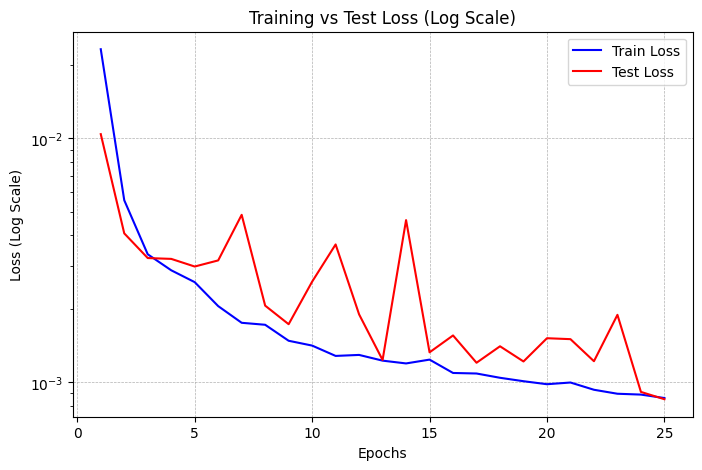

In [25]:
plot_loss_log_scale(train_losses, test_losses)

### Evaluation

Use trained Encoder part to get the features for train, test and evaluation Data

In [26]:
train_features, train_coord_dl = extract_features_ae(trained_model, dataloader_train, device)
test_features, test_coord_dl = extract_features_ae(trained_model, dataloader_test, device)
eval_features, eval_coord_dl = extract_features_ae(trained_model, dataloader_eval, device)

In [27]:
train_features = train_features.cpu()
test_features = test_features.cpu()
eval_features = eval_features.cpu()

In [28]:
combined_train_features = torch.cat((train_features, test_features), dim=0)
combined_train_coords = train_coord_dl + test_coord_dl

K-means on extracted features

In [32]:
kmeans_mvi = train_kmeans_patches(combined_train_features, n_clusters=2, random_state=8)

train_subpatch_predictions = kmeans_mvi.predict(combined_train_features.reshape(combined_train_features.size(0), -1).numpy().astype(np.float32))
eval_subpatch_predictions = kmeans_mvi.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

/home/k64835/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Convert Subpatch labels to Field labels

In [33]:
threshold = config.patch_to_field_threshold
train_field_labels = assign_field_labels_ae(combined_train_coords, train_subpatch_predictions, threshold)
eval_field_labels = assign_field_labels_ae(eval_coord_dl, eval_subpatch_predictions, threshold)

Accuracy and Classification Report

In [38]:
accuracy, report, x_y_coords = evaluate_test_labels_ae(eval_field_labels, config.labels_path)
print(f"Evaluation Accuracy: {accuracy}")
print(report)

Evaluation Accuracy: 0.6229508196721312
              precision    recall  f1-score   support

           0       0.64      0.80      0.71        35
           1       0.59      0.38      0.47        26

    accuracy                           0.62        61
   macro avg       0.61      0.59      0.59        61
weighted avg       0.62      0.62      0.60        61

